In [1]:
class CONSTS:
    fontsize = 16

from conex.helpers.filters import DoGFilter, GaborFilter
from conex.helpers.transforms import Conv2dFilter
import torch
import numpy as np
def filtered(imarray, dog=True, gab=True, size=5, 
             dog_params={"sigma_1": 10.0, "sigma_2": 16.0}, 
             gab_params={"labda": 1.1, "theta": np.pi/2, "sigma": 0.5, "gamma": 0.5}):
    dogFilter = DoGFilter(size=size, **dog_params)
    gabFilter = GaborFilter(size=size, **gab_params)
    filters = []
    if dog:
        filters.append(dogFilter.unsqueeze(0))
    if gab:
        filters.append(gabFilter.unsqueeze(0))
    
    weights = torch.concat(filters).reshape((1, -1, size, size))
    convfil = Conv2dFilter(filters=weights)
    

    imarray2 = torch.concat([imarray, imarray]) if len(filters) == 2 else imarray
    # print(f"im: {imarray2.shape}, dtype: {imarray2.dtype}")

    return convfil(imarray2).squeeze()


rows: 2, cols: 3


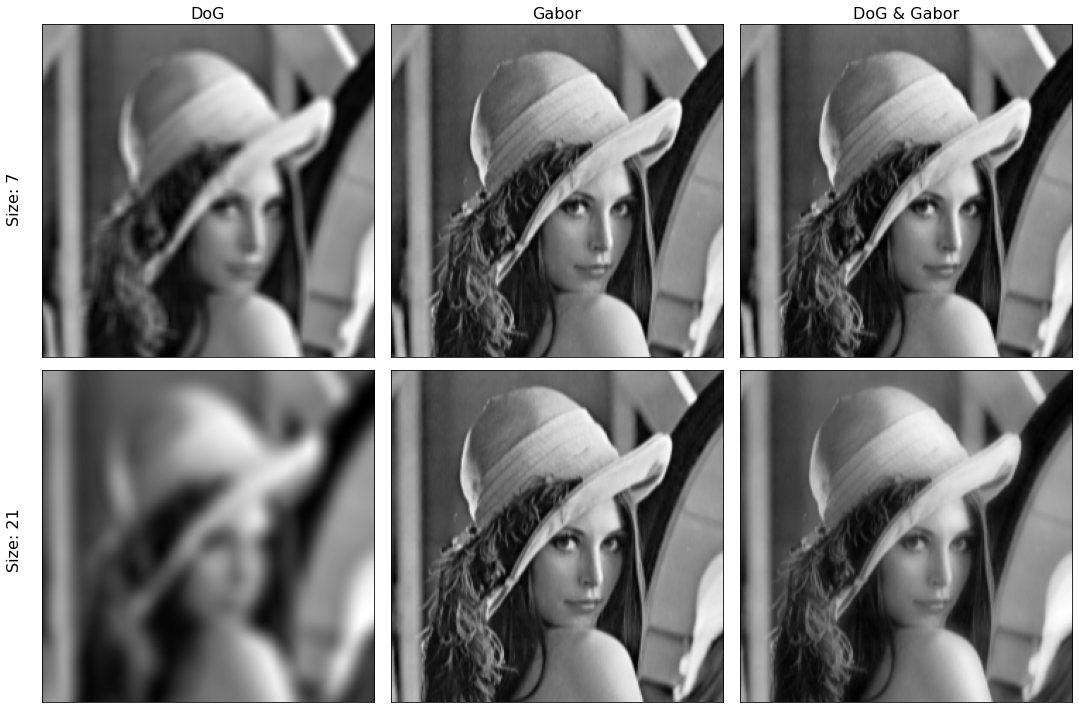

In [2]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

image = Image.open(f"images/lena1.tif")
imarray = torch.tensor(np.array(image)).unsqueeze(0).type(torch.float32)

conv_params = [
    {"dog": True, "gab": False, "size": 7},
    {"dog": False, "gab": True, "size": 7},
    {"dog": True, "gab": True, "size": 7},
    {"dog": True, "gab": False, "size": 21},
    {"dog": False, "gab": True, "size": 21},
    {"dog": True, "gab": True, "size": 21},
    
    ]
conveds = [filtered(imarray=imarray, **param) for param in conv_params]
rows, cols = len(conveds) // 3, 3
print(f"rows: {rows}, cols: {cols}")
fig, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharex=True, sharey=True)

# removing ticks
for a in ax:
    try:
        a.set_xticks([])
        a.set_yticks([])
    except AttributeError:
        for b in a:
            b.set_xticks([])
            b.set_yticks([])

for i in range(len(conveds)):
    if rows == 1:
        ax[i].imshow(conveds[i], cmap="gray")
    else:
        ax[i // 3, i % 3].imshow(conveds[i], cmap="gray")
    
ax[0, 0].set_title("DoG", fontsize=CONSTS.fontsize)
ax[0, 1].set_title("Gabor", fontsize=CONSTS.fontsize)
ax[0, 2].set_title("DoG & Gabor", fontsize=CONSTS.fontsize)
ax[0, 0].text(-25, 140, "Size: 7", rotation="vertical", fontsize=CONSTS.fontsize)
ax[1, 0].text(-25, 140, "Size: 21", rotation="vertical", fontsize=CONSTS.fontsize)
fig.tight_layout()
plt.show()




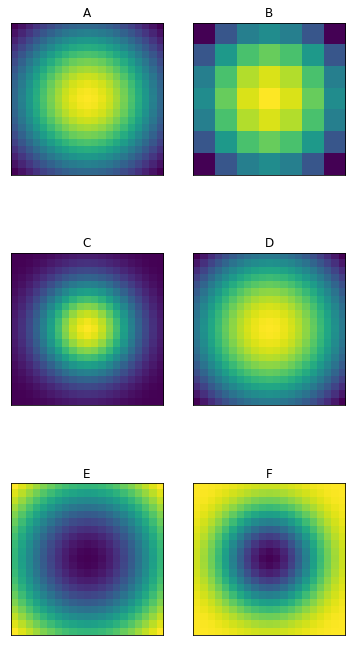

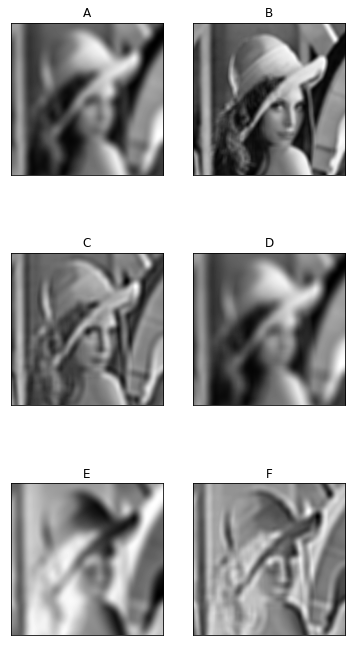

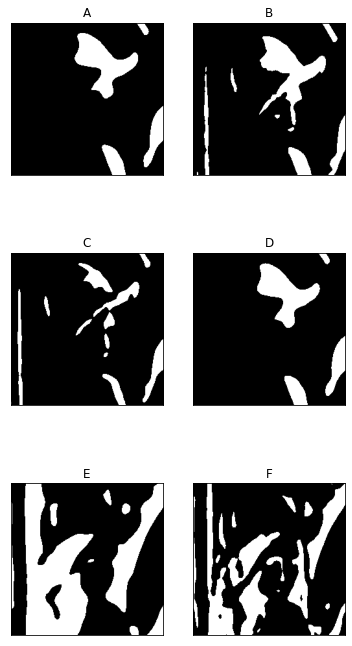

In [3]:
import matplotlib.pyplot as plt
from image_inp import Processor
import torch
import numpy as np

processor = Processor()
processor.load("lena1")

def bigbig(x:torch.Tensor, mul:int):
    a, b = x.shape[0] * mul, x.shape[1]*mul
    y = torch.zeros(a, b)
    for i in range(a):
        for j in range(b):
            y[i, j] = x[i//mul, j//mul]
    return y


dog_params = [
    {"size": 21, "sigma_1": 10.0, "sigma_2": 16.0},
    {"size":  7, "sigma_1": 10.0, "sigma_2": 16.0},
    {"size": 21, "sigma_1": 5.00, "sigma_2": 16.0},
    {"size": 21, "sigma_1": 15.0, "sigma_2": 16.0},
    {"size": 21, "sigma_1": 16.0, "sigma_2": 10.0},
    {"size": 21, "sigma_1": 16.0, "sigma_2": 5.00},
]
gabs_params = [
    {"size": 7 , "labda": 1.0, "theta": np.pi/2, "sigma": 1.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.0, "theta": np.pi/2, "sigma": 1.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.0, "theta": np.pi/2, "sigma": 0.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.0, "theta": np.pi/2, "sigma": 2.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.0, "theta": np.pi/2, "sigma": 1.5, "gamma": 0.05},
    {"size": 21, "labda": 1.0, "theta": np.pi/2, "sigma": 1.5, "gamma": 0.5 },
    {"size": 21, "labda": 0.5, "theta": np.pi/2, "sigma": 1.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.5, "theta": np.pi/2, "sigma": 1.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.0, "theta": np.pi/4, "sigma": 1.5, "gamma": 0.1 },
    {"size": 21, "labda": 1.0, "theta": np.pi/3, "sigma": 1.5, "gamma": 0.1 },

]

filter, params = (('gabor', gabs_params), ('dog', dog_params))[1]
encoder_params = {'time': 100, 'neurons_count': 256*256, 'theta': 1.5, 'epsilon': 0.001}

fig0, ax0 = plt.subplots(len(params)//2, 2, figsize=(6, 12), sharex=True, sharey=True)
fig1, ax1 = plt.subplots(len(params)//2, 2, figsize=(6, 12), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(len(params)//2, 2, figsize=(6, 12), sharex=True, sharey=True)

# removing ticks
for ax in (ax2, ax1, ax0):
    for a in ax:
        for b in a:
            b.set_xticks([])
            b.set_yticks([])
for i in range(len(params)):
    the_filter = processor.get_filter(filter_name=filter, params=params[i])
    conved = processor.apply_filter(filter_name=filter, params=params[i])
    encoded:torch.Tensor = processor.apply_encoding(encoder_name='ttfs', encoder_params=encoder_params, filter_name=filter, filter_params=params[i])
    summed = encoded[:11].sum(dim=0)

    the_filter = the_filter.squeeze().squeeze()
    if params[i]['size'] == 7:the_filter = bigbig(the_filter,3)
    ax0[i // 2, i % 2].imshow(the_filter)
    ax1[i // 2, i % 2].imshow(conved, cmap="gray")
    ax2[i // 2, i % 2].imshow(summed, cmap="gray")

for i in range(len(params)):
    ax0[i // 2, i % 2].set_title(chr(65 + i))
    ax1[i // 2, i % 2].set_title(chr(65 + i))
    ax2[i // 2, i % 2].set_title(chr(65 + i))



In [1]:
from model import ModelSTDP
from image_inp import Processor

processor = Processor()
processor.load("lena1")
encoded = processor.apply_encoding(encoder_name='ttfs', 
                                   encoder_params={'time': 100, 'neurons_count': 256*256, 'theta': 1.5, 'epsilon': 0.001},
                                   filter_name='dog',
                                   filter_params={"size": 21, "sigma_1": 5.00, "sigma_2": 16.0})
    
model = ModelSTDP(in_size=236 * 236, out_size=2, mid_size=4, R=200)
inputs = encoded.flatten(1)[:11]
print(inputs.shape)
model.fit(inputs, periodic=True, iterations=10)



torch.Size([11, 55696])
inputs.py: spikes: 5379


In [3]:
print(model.outLayer['spikes'][0].shape)


torch.Size([80, 2])
